In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV

In [2]:
# Load the files
category_tree = pd.read_csv('archive/category_tree.csv')

events = pd.read_csv('archive/events.csv')
item_properties_part1 = pd.read_csv('archive/item_properties_part1.csv')
item_properties_part2 = pd.read_csv('archive/item_properties_part2.csv')

# join the 2 item property files 
item_properties = pd.concat([item_properties_part1, item_properties_part2])

In [14]:
# item_properties.head()
category_tree.head()


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [15]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [7]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [9]:
events.itemid.nunique()

235061

In [60]:
# convert timestamp to readable dates
events['date_time'] = pd.to_datetime(events['timestamp'],unit='ms')
events.head(2)

,timestamp,visitorid,event,itemid,transactionid,date_time
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164


In [61]:
events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [62]:
events.shape

(2756101, 6)

In [63]:
# remove duplicate rows
events.drop_duplicates(inplace=True)
events.shape

(2755641, 6)

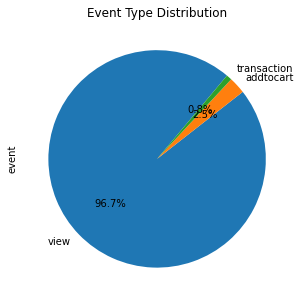

In [64]:
# Event Distribution
event_counts = events['event'].value_counts()
event_percentage = (event_counts / len(events) * 100)
plt.figure(figsize=(5, 5))
event_percentage.plot(kind='pie', autopct='%1.1f%%', startangle=50)
plt.title('Event Type Distribution')
plt.show()

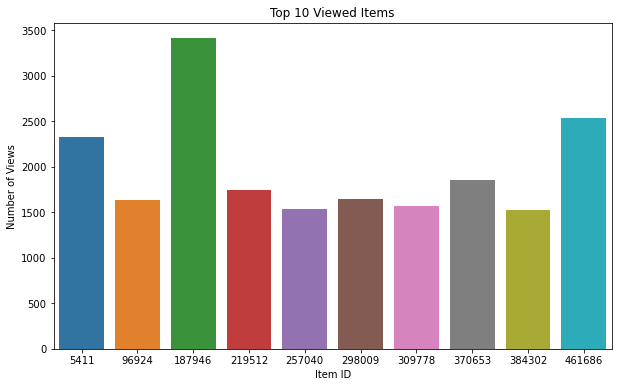

In [65]:
# Most viewed items by users
top_viewed_items = events[events['event'] == 'view']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

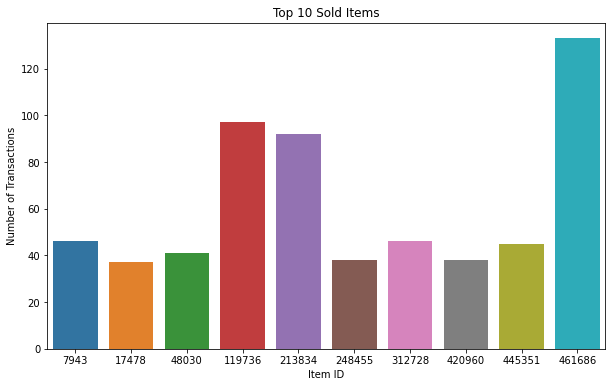

In [66]:
# Most sold items
top_sold_items = events[events['event'] == 'transaction']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values)
plt.title('Top 10 Sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Transactions')
plt.show()

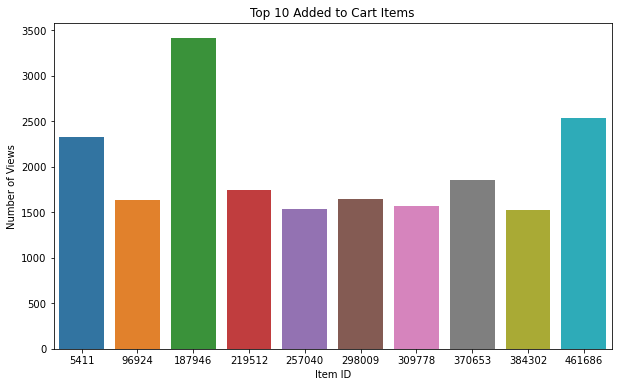

In [67]:
# most added to cart items
top_atc_items = events[events['event'] == 'addtocart']['itemid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values)
plt.title('Top 10 Added to Cart Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

In [68]:
#It allows you to focus on data related to transaction events for further analysis or processing.

item_tra=events[['visitorid','itemid','date_time']][events['event']=='transaction']
item_tra.head()

,visitorid,itemid,date_time
130,599528,356475,2015-06-02 05:17:56.276
304,121688,15335,2015-06-01 21:18:20.981
418,552148,81345,2015-06-01 21:25:15.008
814,102019,150318,2015-06-01 16:38:56.375
843,189384,310791,2015-06-01 16:01:58.180


In [69]:
# Merge events with item properties and category tree
merged_data = events.merge(item_properties, on=['itemid', 'timestamp'], how='left').merge(category_tree, left_on='property', right_on='categoryid', how='left')

In [70]:
merged_data.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,NaN,NaN,NaN,NaN


In [71]:
merged_data.shape

(2755641, 10)

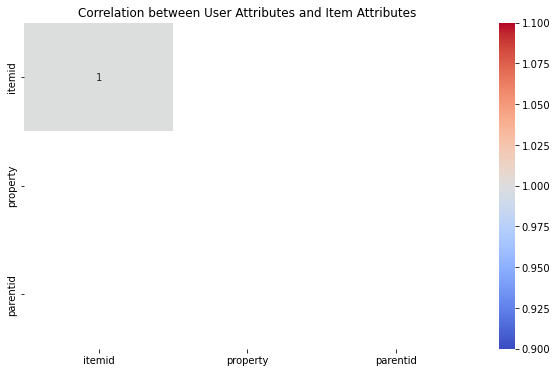

Add-to-cart to transaction conversion rate: 32.56%


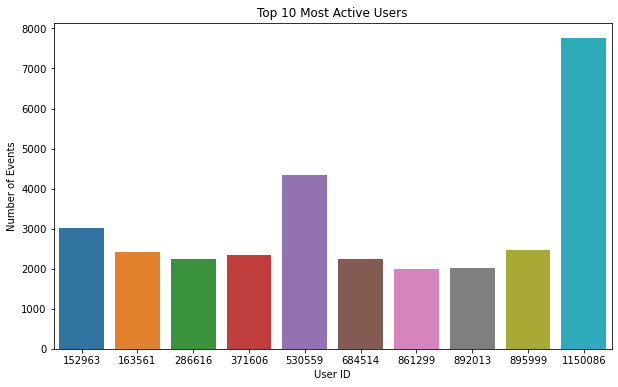

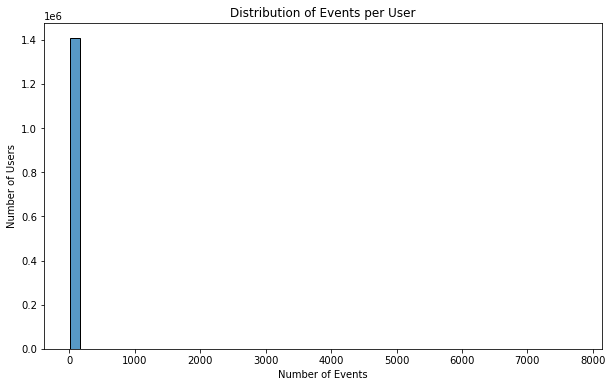

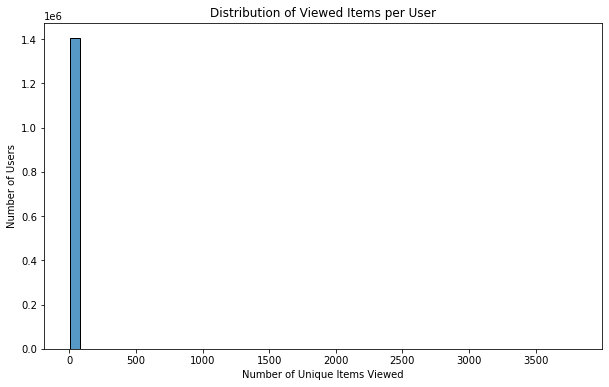

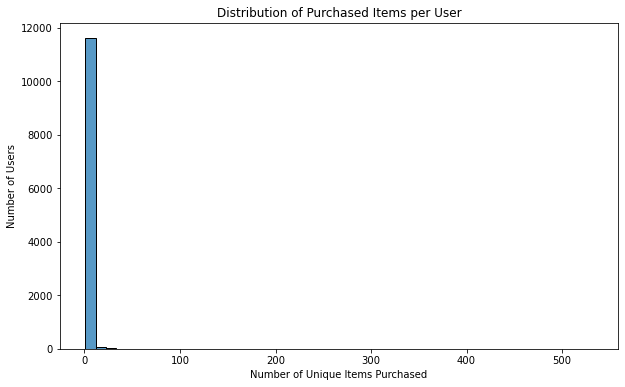

In [72]:
# Correlation between user attributes and item attributes
user_item_merged = merged_data.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
})

correlation_matrix = user_item_merged.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between User Attributes and Item Attributes')
plt.show()

# Add-to-cart to transaction conversion rate
add_to_cart = events[events['event'] == 'addtocart']
transactions = events[events['event'] == 'transaction']
conversion_rate = len(transactions) / len(add_to_cart)

print(f"Add-to-cart to transaction conversion rate: {conversion_rate:.2%}")

#  Most active users
top_active_users = events['visitorid'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_active_users.index, y=top_active_users.values)
plt.title('Top 10 Most Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Events')
plt.show()

# Distribution of events per user
events_per_user = events['visitorid'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(events_per_user, kde=False, bins=50)
plt.title('Distribution of Events per User')
plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.show()

# Distribution of viewed items per user
viewed_items_per_user = events[events['event'] == 'view'].groupby('visitorid')['itemid'].nunique()
plt.figure(figsize=(10, 6))
sns.histplot(viewed_items_per_user, kde=False, bins=50)
plt.title('Distribution of Viewed Items per User')
plt.xlabel('Number of Unique Items Viewed')
plt.ylabel('Number of Users')
plt.show()

# Distribution of purchased items per user
purchased_items_per_user = events[events['event'] == 'transaction'].groupby('visitorid')['itemid'].nunique()
plt.figure(figsize=(10, 6))
sns.histplot(purchased_items_per_user, kde=False, bins=50)
plt.title('Distribution of Purchased Items per User')
plt.xlabel('Number of Unique Items Purchased')
plt.ylabel('Number of Users')
plt.show()

In [78]:
# copy the merged data into a new dataframe
df = merged_data.copy()

In [79]:
# Feature engineering
## User-based features
user_behavior = df.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
    'timestamp': ['min', 'max', 'mean']
}).reset_index()

user_behavior.columns = ['visitorid', 'item_count', 'property_count', 'category_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior['time_on_platform'] = user_behavior['last_interaction'] - user_behavior['first_interaction']
user_behavior['time_between_actions'] = user_behavior['time_on_platform'] / (user_behavior['item_count'] - 1)

## Item-based features
item_popularity = df.groupby('itemid').agg({
    'visitorid': 'count',
    'event': ['nunique', lambda x: sum(x == 'view'), lambda x: sum(x == 'addtocart'), lambda x: sum(x == 'transaction')]
}).reset_index()

item_popularity.columns = ['itemid', 'user_count', 'event_count', 'view_count', 'addtocart_count', 'transaction_count']
item_popularity['conversion_rate'] = item_popularity['transaction_count'] / item_popularity['addtocart_count']

## User-item interaction features
user_item_interactions = df.groupby(['visitorid', 'itemid']).agg({
    'event': 'count',
    'timestamp': ['min', 'max']
}).reset_index()

user_item_interactions.columns = ['visitorid', 'itemid', 'interaction_count', 'first_interaction', 'last_interaction']
user_item_interactions['time_between_interactions'] = user_item_interactions['last_interaction'] - user_item_interactions['first_interaction']

## Merge the features into a single DataFrame
user_features = user_behavior.drop(['first_interaction', 'last_interaction'], axis=1)
item_features = item_popularity.drop(['view_count', 'addtocart_count', 'transaction_count'], axis=1)
interaction_features = user_item_interactions.drop(['first_interaction', 'last_interaction'], axis=1)

features = interaction_features.merge(user_features, on='visitorid').merge(item_features, on='itemid')

In [80]:
features.head(5)

,visitorid,itemid,interaction_count,time_between_interactions,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion_rate
0,0,67045,1,0,3,0,0,1.442005e+12,327736,1.638680e+05,205,3,0.5
1,2304,67045,1,0,21,0,0,1.431566e+12,4357600,2.178800e+05,205,3,0.5
2,15257,67045,1,0,1,0,0,1.434802e+12,0,NaN,205,3,0.5
3,42552,67045,3,9717445035,158,0,0,1.435883e+12,10201702006,6.497899e+07,205,3,0.5
4,45810,67045,1,0,1,0,0,1.434829e+12,0,NaN,205,3,0.5


In [3]:
import pandas as pd

def count_events_for_itemid(data, itemid):
    # Convert the data dictionary to a DataFrame
    df = pd.DataFrame(data)
    
    # Filter the DataFrame for the specified itemid
    item_data = df[df['itemid'] == itemid]
    
    # Count the occurrences of each event for the itemid
    event_counts = item_data['event'].value_counts().to_dict()
    
    # Return the counts
    return event_counts

# Example usage
data = {
    'timestamp': [1433221332117, 1433224214164, 1433221999827, 1433221955914, 1433221337106],
    'visitorid': [257597, 257597, 111016, 483717, 257597],
    'event': ['view', 'transaction', 'view', 'addtocart', 'view'],
    'itemid': [355908, 248676, 355908, 355908, 367447],
    'transactionid': [None, None, None, None, None]
}

itemid_to_query = 355908  # Replace with the desired itemid
result = count_events_for_itemid(data, itemid_to_query)

print(f"Event counts for itemid {itemid_to_query}:")
print(result)


Event counts for itemid 355908:
{'view': 2, 'addtocart': 1}
